In [1]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0.3.0
Python version: 3.7.9 (default, Aug 31 2020, 07:22:35)  [Clang 10.0.0 ]
OS version: Darwin (19.6.0)
Numpy version: 1.19.1
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 3.12.2
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
root_dir = "MONAI_DATA_DIRECTORY"
print(root_dir)

MONAI_DATA_DIRECTORY


In [3]:
resource = "https://drive.google.com/uc?id=1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [4]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [5]:
set_determinism(seed=0)

In [6]:
train_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
        #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


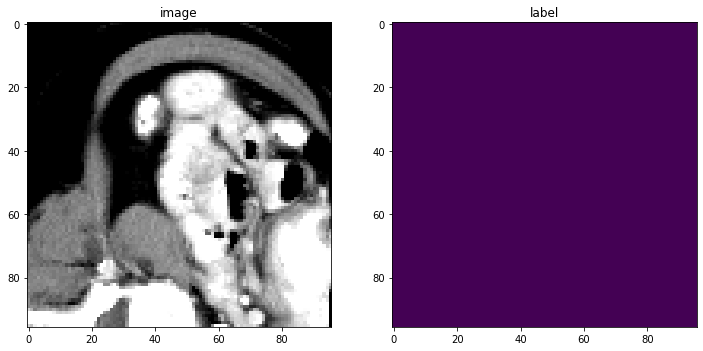

In [13]:
check_ds = Dataset(data=val_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 10], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 10])
plt.show()

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


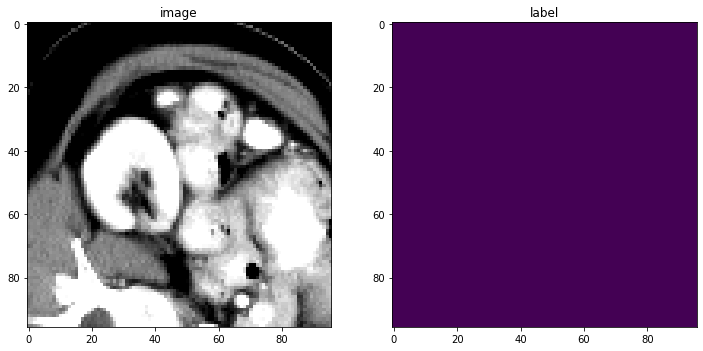

In [16]:
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30])
plt.show()